In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd

In [2]:
def LFfunction(M, Ms, alpha):
    dm = 0.4*(Ms-M)
    c = 10.**dm
    b = c**(alpha+1)
    
    return b/np.exp(c)

In [3]:
def Velocity_PDF(x, val, bin):
    
    N = len(val)
    for i in range(N):
        if bin[i]<=x and x<bin[i+1]:
            return val[i]
    return None

In [4]:
####################################### Set Axes
def set_axes(ax, xlim=None, ylim=None, fontsize=16, twinx=True, twiny=True, minor=True, inout='in'):
        
        if not ylim is None:
            ax.set_ylim(ylim)
        else:
            ylim = ax.get_ylim() 
            
        if not xlim is None:    
            ax.set_xlim(xlim) 
        else:
            xlim = ax.get_xlim()
            
        ax.tick_params(which='major', length=6, width=1., direction=inout)
#         if minor:
        ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)  
        
        if twiny:
            y_ax = ax.twinx()
            y_ax.set_ylim(ylim)
            y_ax.set_yticklabels([])
            y_ax.minorticks_on()
            y_ax.tick_params(which='major', length=6, width=1., direction=inout)
            if minor:
                y_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout) 
        
        if twinx:
            x_ax = ax.twiny()
            x_ax.set_xlim(xlim)
            x_ax.set_xticklabels([])
            x_ax.minorticks_on()
            x_ax.tick_params(which='major', length=6, width=1.0, direction=inout)
            if minor:
                x_ax.tick_params(which='minor', length=3, color='#000033', width=1.0, direction=inout)     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(fontsize) 
        
        return x_ax, y_ax

In [5]:
band = 'w1'
## Luminosity function parameters
alpha = -1
Ms = -21.9

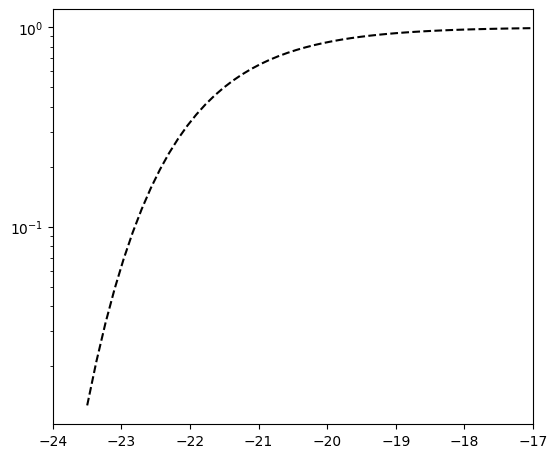

In [6]:
fig = py.figure(figsize=(6,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.95, bottom=0.12, left=0.15, right=0.95)
ax = fig.add_subplot(111)
ax.set_xlim([-24,-17])

M = np.linspace(-23.5,-17,50)
N = LFfunction(M, Ms, alpha)
ax.plot(M, N,'k--')

ax.set_yscale("log", nonposy='clip')

(array([  651.,  5666., 15305., 22733., 26674., 28455., 29428., 29513.,
        29797., 29915.]),
 array([-23.95510363, -22.95959574, -21.96408785, -20.96857996,
        -19.97307207, -18.97756418, -17.98205629, -16.9865484 ,
        -15.99104051, -14.99553262, -14.00002473]),
 <a list of 10 Patch objects>)

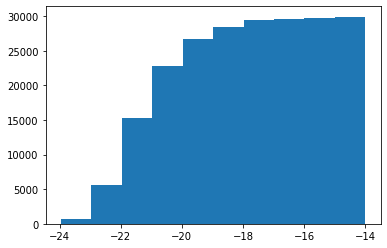

In [7]:
np.random.seed(10)
size = 300000
randMGAG = np.random.uniform(low=-24, high=-14, size=size)

randU = np.random.uniform(low=0, high=1, size=size)
randLfunct = LFfunction(randMGAG, Ms, alpha)
indx, = np.where(randU<randLfunct)
simulMag  = randMGAG[indx]

plt.hist(simulMag)

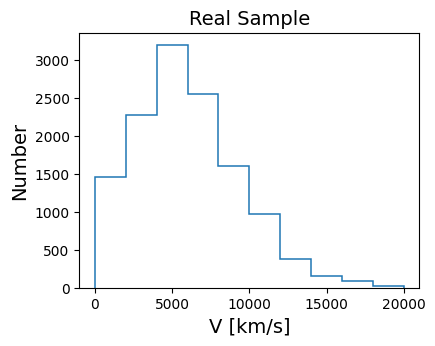

500593


Text(0.5, 1.0, 'Simulated Sample [before cut]')

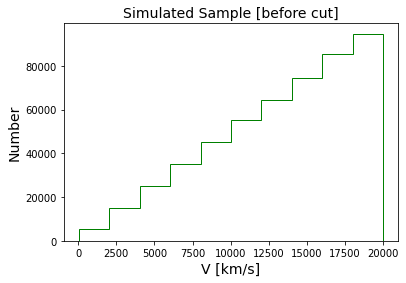

In [8]:
df = pd.read_csv('../CF4catalog/TFR_CF4_components_bar', delimiter='|')

# revising the column names
for col in df.columns:
    newcol = col.strip()
    df.rename(columns={col:newcol}, inplace=True)


df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

fig = plt.figure(figsize=(4,3), dpi=100)
ax = fig.add_axes([0.13, 0.1, 0.85,  0.85])
bins=np.arange(0, 22000, 2000)
val = df[df["DM_cf4"]!=0]["Vcmb"].values
param = ax.hist(val, bins=bins, histtype='step', label='cf4+'+str(len(val)), lw=1.1) 
val = param[0]
bin = param[1]

ax.set_xlabel("V [km/s]", fontsize=14)
ax.set_ylabel("Number", fontsize=14)
ax.set_title("Real Sample", fontsize=14)

plt.show();


size = 1000000

### Sample distribution
# randU1 = np.random.uniform(low=0, high=20000, size=size)
# y = np.asarray([Velocity_PDF(b, val, bin) for b in randU1])
# randU2 = np.random.uniform(low=0, high=np.max(val), size=size)
# indx, = np.where(randU2<y)
# V_cf4 = randU1[indx]

### parabolic distribution
randU1 = np.random.uniform(low=0, high=20000, size=size)   # velocity
y = 5*(randU1/10000.)**1

randU2 = np.random.uniform(low=0, high=np.max(y), size=size)
indx, = np.where(randU2<y)
V_cf4 = randU1[indx]

print(len(V_cf4))

plt.hist(V_cf4, histtype='step', color='green')
plt.xlabel("V [km/s]", fontsize=14)
plt.ylabel("Number", fontsize=14)
plt.title("Simulated Sample [before cut]", fontsize=14)

In [9]:
N = len(simulMag)
V_cf4 = V_cf4[:N]
D75 = V_cf4 / 75.

N

218137

In [10]:
len(V_cf4)

218137

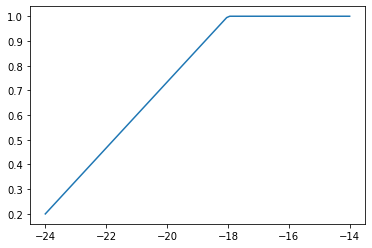

In [11]:
def frac_(Mag):
    
    if Mag>-18:
        return 1.
    else:
        m = 0.8 / 6.
        z = 1. + m*18.
        fb = m * Mag + z
        return fb
    
    

def frac(Mag):
    
    f = Mag * 0
    
    m = 0.8 / 6.
    z = 1. + m*18.
    fb = m * Mag + z
    
    f[np.where(Mag>-18)] = 1.
    
    indx, = np.where(Mag<-18)
    f[indx] = fb[indx]
    
    return f


x = np.linspace(-24,-14,100)
y = frac(x)
    
plt.plot(x, y)

In [12]:
frac_(-22.)

0.4666666666666668

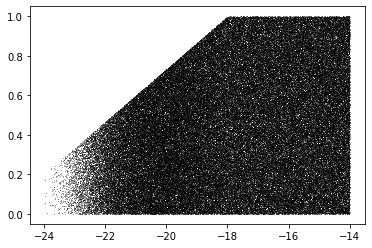

In [13]:
f_gas = np.asarray([np.random.uniform(low=0, high=frac_(Mag), size=1)[0] for Mag in simulMag])

plt.plot(simulMag, f_gas, 'ko', alpha=0.5, ms=1, mfc='k', mec='none')

In [14]:
t = 1./(1./f_gas-1)

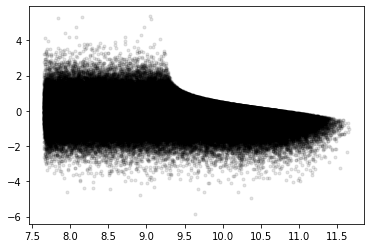

In [15]:
logMs = np.log10(0.5) + 0.4*5.91 - 0.4*simulMag

plt.plot(logMs, np.log10(t), 'k.', alpha=0.1)

In [16]:
logMs = np.log10(0.5) + 0.4*5.91 - 0.4*simulMag + np.random.normal(0, 0.05, N)

Ms = 10**logMs

# (7.424 - 0.763 * logMs )

logscatter = np.random.normal(0, 0.432/2, N)   ### 0.432/2

logMg_Ms = (7.424 + 0) + (-0.763 + 0) * logMs


t = 10**logMg_Ms
f = 1./(1./t+1)
f = np.asarray([np.random.uniform(low=0, high=x, size=1)[0] for x in f])
t = 1./(1./f-1)


logMg_Ms = np.log10(t) #+ logscatter

Mg_Ms = 10**logMg_Ms

In [17]:
Mg = Ms * Mg_Ms
logMg = np.log10(Mg)
Mhi = Mg / 1.33
logMhi = np.log10(Mhi)
Mb = Mg + Ms
logMb = np.log10(Mb)
F21 = Mhi / (2.356E5 * (D75**2))
logF21 = np.log10(F21)

# logW = (logMb - 10.320+np.random.normal(0, 0.027, N_))/(3.317+np.random.normal(0, 0.025, N_)) + 2.5
logW = (logMb-10.341)/3.317 + 2.5 # + np.random.normal(0, 0.05, N_)

In [18]:
cut, = np.where((logF21>0)&(logF21<10)) # &(Mg_Ms<10)

Ms_ = Ms[cut] #10**(logMs + np.random.normal(0, 0.1, N))
N_ = len(Ms_)
logMs_  = logMs[cut]
Mg_     = Mg[cut]
logMg_  = logMg[cut]
Mhi_    = Mhi[cut]
logMhi_ = logMhi[cut]
Mb_     = Mb[cut]
logMb_  = logMb[cut]
F21_    = F21[cut]
logF21_ = logF21[cut]
V_cf4_  = V_cf4[cut]
simulMag_ = simulMag[cut]
D75_     = D75[cut]
logW_ = logW[cut]

N_

15371

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b5b959310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1b5bde9d90>)

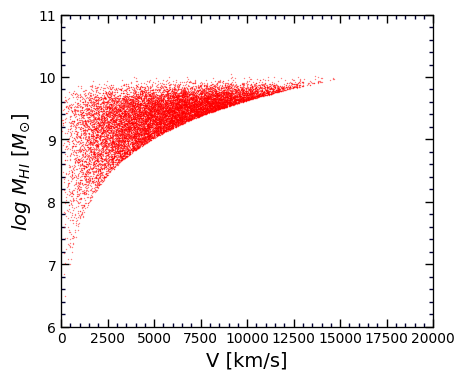

In [19]:
fig = py.figure(figsize=(4,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.plot(V_cf4_, logMhi_, 'ro', alpha=0.5, ms=1, mfc='r', mec='none')

ax.set_xlabel("V [km/s]", fontsize=14)
ax.set_ylabel(r"$log \/\/ M_{HI} \/\/ [M_{\odot}]$", fontsize=14)

set_axes(ax, (0,20000),(6,11), fontsize=10)

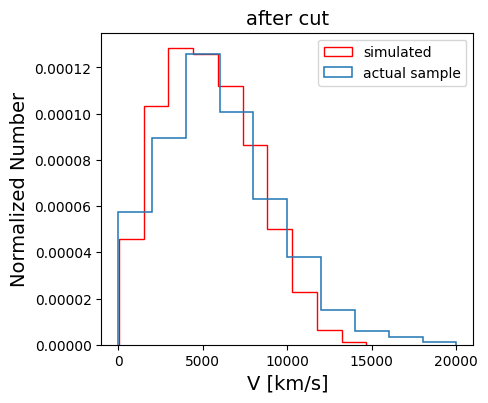

In [20]:
fig = py.figure(figsize=(4,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.hist(V_cf4_, histtype='step', color='red', density=True, label='simulated')
ax.set_xlabel("V [km/s]", fontsize=14)
ax.set_ylabel("Normalized Number", fontsize=14)
ax.set_title("after cut", fontsize=14)

bins=np.arange(0, 22000, 2000)
val = df[df["DM_cf4"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', lw=1.1, density=True, label='actual sample') 

ax.legend()

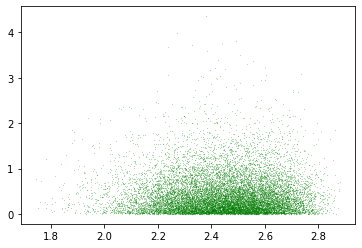

In [21]:
plt.plot(logW_, logF21_, 'go', alpha=0.3, ms=1.2, mfc='g', mec='none')

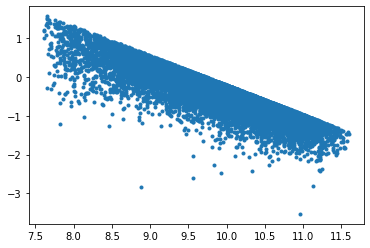

In [22]:
plt.plot(logMs_, np.log10(Mg_/Ms_), '.')

(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b5b5b2430>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1b5b5fc7f0>)

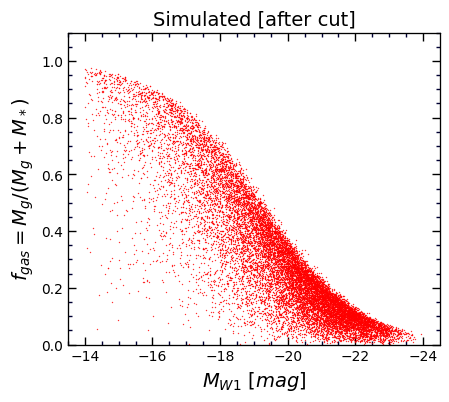

In [23]:
fig = py.figure(figsize=(4,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.plot(simulMag_, Mg_/Mb_, 'ro', alpha=0.8, ms=1, mfc='r', mec='none')

ax.set_xlabel(r"$M_{W1} \/\/ [mag]$", fontsize=14)
ax.set_ylabel(r"$f_{gas}=M_g/(M_g+M_*)$", fontsize=14)
ax.set_title("Simulated [after cut]", fontsize=14)

set_axes(ax, (-13.5,-24.5),(0,1.1), fontsize=10)

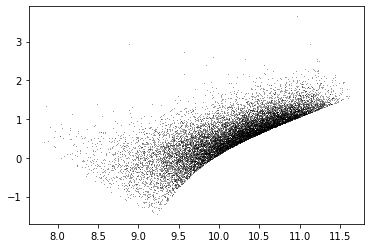

In [24]:
X0 = logMb_
Y0 = logMs_ - logMhi_

plt.plot(X0, Y0, 'ko', alpha=0.5, ms=1, mfc='k', mec='none')

In [25]:
def linear(x, m, b):
    return m*x+b

def linear_m(x, m):
    return m*x

2.5819912548367485 -5.4792682589304125


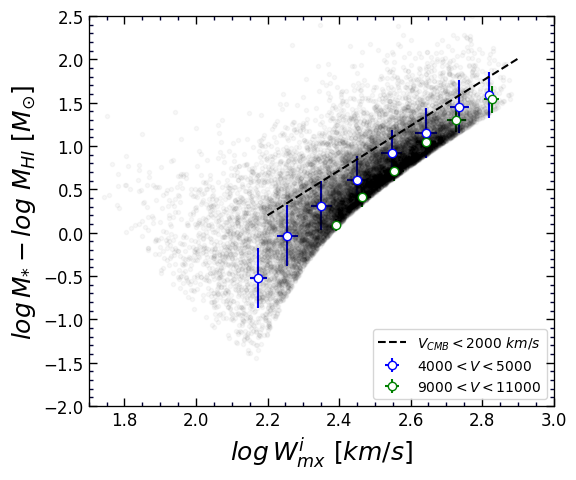

In [26]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X0 = logW_
Y0 = logMs_ - logMhi_
V3k = V_cf4_

ax.plot(X0, Y0, 'k.', alpha=0.03)

label=r'$4000<V<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label=r'$9000<V<11000$'
lab = True
ind, = np.where((V3k>9000)&(V3k<10000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)            
        
        
label=r'$15000<V$'
lab = True      
ind, = np.where((V3k>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3.0,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{*}-log \/\/ M_{HI} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (-2,2.5), fontsize=12)




x = np.linspace(2.2, 2.9, 100)
ind, = np.where((X0>2.2)&(V3k>0)&(V3k<2000)&(X0<2.9))
fit, cov = curve_fit(linear, X0[ind], Y0[ind])
m, b = fit[0], fit[1]
ax.plot(x, m*x + b, '--', color='k', label=r'$V_{CMB}<2000 \/\/ km/s$')

print(m,b)

ax.legend()

-4.634515827822518e-05 [[3.6355906e-07]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b5a6651c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1b5a7561c0>)

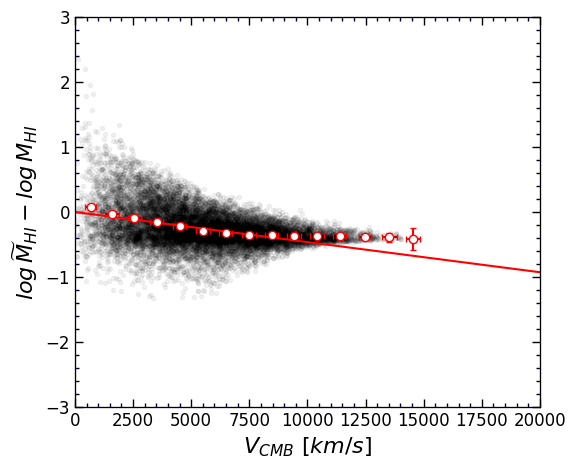

In [27]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = Y0-(m*X0+b)
X = V3k

X = X[X0>2.2]
Y = Y[X0>2.2]
ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0, 20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        
        N = len(xp)
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.mean(yp)/np.sqrt(N), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe, capsize=2) 

x = np.linspace(0,20000,1000)
fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
mc = fit[0] #; bc=fit[1]
ax.plot(x, mc*x, '-', color='r')
print(mc, np.sqrt(cov))

# ff, cov = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2, cov=True)
# x = np.linspace(0,5000,1000)
# y = x*0.
# n = len(ff)
# for i in range(n):
#     y += ff[i]*x**(n-i-1)

    
# ax.plot(x, y, '--', color='g')

ax.set_ylabel(r'$log \/\widetilde{M}_{HI}  - log\/ M_{HI}$', fontsize=16) 
ax.set_xlabel(r'$V_{CMB} \/\/ [km/s] $', fontsize=16)
set_axes(ax, (0, 20000), (-3,3), fontsize=12)

# ax.ticklabel_format(useMathText=True)

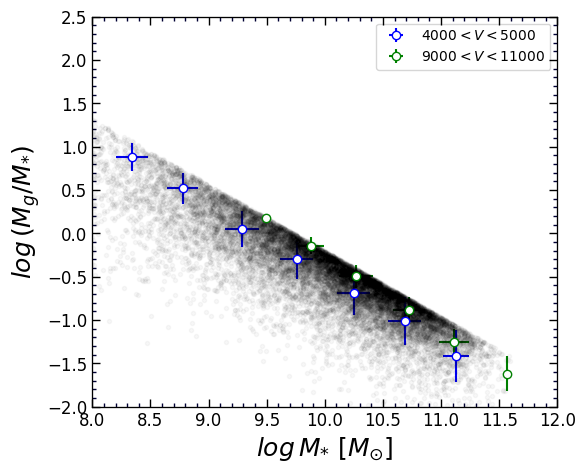

In [28]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X0 = logMs_
Y0 = logMg_-np.log10(Ms_)
V3k = V_cf4_

ax.plot(X0, Y0, 'k.', alpha=0.03)

label=r'$4000<V<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(8,12,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label=r'$9000<V<11000$'
lab = True
ind, = np.where((V3k>9000)&(V3k<10000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(8,12,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)            
        
        
label=r'$15000<V$'
lab = True      
ind, = np.where((V3k>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(8,12,0.5):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.5:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ M_{*} \/\/ [M_{\odot}]$', fontsize=18) 
ax.set_ylabel(r'$log \/ (M_g/M_{*})\/\/ $', fontsize=18)
set_axes(ax, (8,12), (-2,2.5), fontsize=12)




ax.legend()

In [29]:
m0 = 3.317
b0 = 10.341
gamma = np.log10(0.5) + 0.4*5.91

N = len(Mg_Ms)
logMg_Ms = np.log10(Mg_Ms) + logscatter
Mg = Ms * 10**logMg_Ms
Mhi = Mg / 1.33
logMs = np.log10(Ms)
logMhi = np.log10(Mhi)
F21 = Mhi / (2.356E5 * (D75**2))
logF21 = np.log10(F21)

# logW = logW + np.random.normal(0, 0.02, N) 

cut, = np.where((logF21>0)&(logF21<10)) 

F21_    = F21[cut]
logF21_ = logF21[cut]
D75_ = D75[cut]
simulMag_ = simulMag[cut]
Ms_ = Ms[cut]
logMs_ = logMs[cut]
logMhi_ = logMhi[cut]
V_cf4_ = V_cf4[cut]
logW_ = logW[cut]

N_ = len(logW_)

mag  = simulMag_+5*np.log10(D75_)+25.
DM75_ = 5*np.log10(D75_)+25

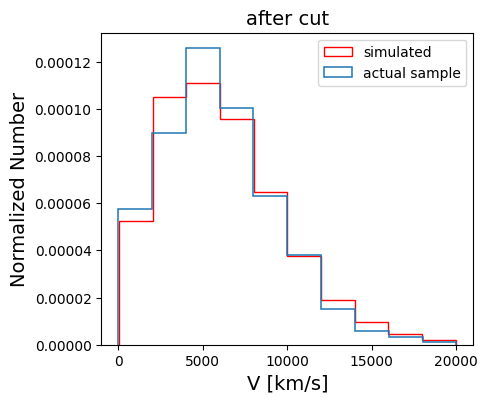

In [30]:
fig = py.figure(figsize=(4,4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

ax.hist(V_cf4_, histtype='step', color='red', density=True, label='simulated')
ax.set_xlabel("V [km/s]", fontsize=14)
ax.set_ylabel("Normalized Number", fontsize=14)
ax.set_title("after cut", fontsize=14)

bins=np.arange(0, 22000, 2000)
val = df[df["DM_cf4"]!=0]["Vcmb"].values
ax.hist(val, bins=bins, histtype='step', lw=1.1, density=True, label='actual sample') 

ax.legend()

2.488806242793286 -5.244844247877853


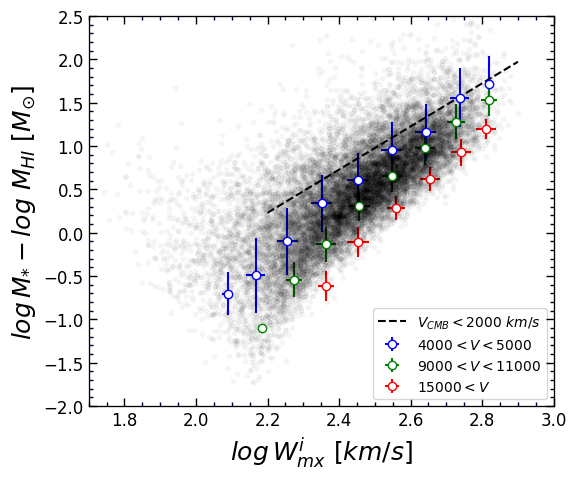

In [31]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

X0 = logW_
Y0 = logMs_ - logMhi_
V3k = V_cf4_

ax.plot(X0, Y0, 'k.', alpha=0.03)

label=r'$4000<V<5000$'
ind, = np.where((V3k>4000)&(V3k<5000))
X = X0[ind]
Y = Y0[ind]
lab = True
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None        
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='blue', ms=6, mfc='white', label=labe)            
        

label=r'$9000<V<11000$'
lab = True
ind, = np.where((V3k>9000)&(V3k<10000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='green', ms=6, mfc='white', label=labe)            
        
        
label=r'$15000<V$'
lab = True      
ind, = np.where((V3k>15000))
X = X0[ind]
Y = Y0[ind]
for i in np.arange(2,3.0,0.1):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+0.1:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe)             
        
ax.set_xlabel(r'$log \/ W_{mx}^i \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$log \/ M_{*}-log \/\/ M_{HI} \/\/ [M_{\odot}]$', fontsize=18)
set_axes(ax, (1.7,3), (-2,2.5), fontsize=12)




x = np.linspace(2.2, 2.9, 100)
ind, = np.where((X0>2.2)&(V3k>0)&(V3k<2000)&(X0<2.9))
fit, cov = curve_fit(linear, X0[ind], Y0[ind])
m, b = fit[0], fit[1]
ax.plot(x, m*x + b, '--', color='k', label=r'$V_{CMB}<2000 \/\/ km/s$')

print(m,b)

ax.legend()

-5.790242875052191e-05 [[4.56732472e-07]]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f1b539d6f10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f1b53e80a90>)

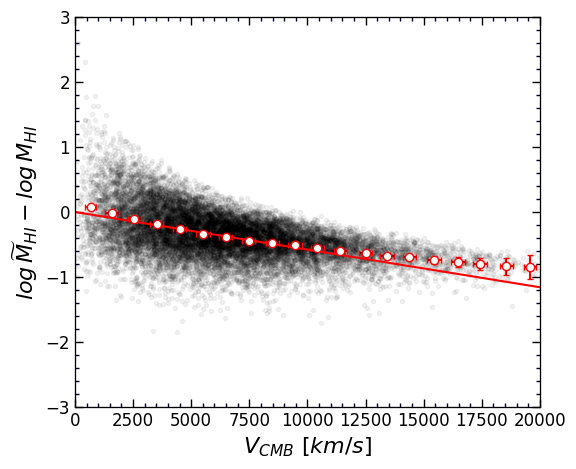

In [32]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


Y = Y0-(m*X0+b)
X = V3k

X = X[X0>2.2]
Y = Y[X0>2.2]
ax.plot(X, Y, 'k.', alpha=0.05)

for i in np.arange(0, 20000, 1000):
    xp = []
    yp = []
    for ii in range(len(X)):
        xi = X[ii]
        if xi>=i and xi<i+1000:
            xp.append(xi)
            yp.append(Y[ii])
    if len(xp)>0:
        if lab:
            labe = label
            lab = False
        else:
            labe=None   
        
        N = len(xp)
        ax.errorbar(np.median(xp), np.mean(yp), yerr=np.mean(yp)/np.sqrt(N), xerr=np.std(xp), fmt='o', 
                    color='red', ms=6, mfc='white', label=labe, capsize=2) 

x = np.linspace(0,20000,1000)
fit, cov = curve_fit(linear_m, X[(X>4000)&(X<10000)], Y[(X>4000)&(X<10000)])
mc = fit[0] #; bc=fit[1]
ax.plot(x, mc*x, '-', color='r')
print(mc, np.sqrt(cov))

# ff, cov = np.polyfit(X[(X<5000)&(Y>-3)], Y[(X<5000)&(Y>-3)], 2, cov=True)
# x = np.linspace(0,5000,1000)
# y = x*0.
# n = len(ff)
# for i in range(n):
#     y += ff[i]*x**(n-i-1)

    
# ax.plot(x, y, '--', color='g')

ax.set_ylabel(r'$log \/\widetilde{M}_{HI}  - log\/ M_{HI}$', fontsize=16) 
ax.set_xlabel(r'$V_{CMB} \/\/ [km/s] $', fontsize=16)
set_axes(ax, (0, 20000), (-3,3), fontsize=12)

# ax.ticklabel_format(useMathText=True)

In [33]:
def HI_corrector(mc, bc, V3k):
    
    return mc*V3k+bc

def getDM(mag, Wlog, F21, m0, b0, D, V3k, correct=False):
    
    Mb = 10**(m0*(Wlog-2.5)+b0)
    
    M21 = 2.356E5 * F21 * (D**2)
    
    if correct: 
        M21 = 10**(np.log10(M21) + HI_corrector(mc, 0, V3k))
    else:
        M21 = 10**(np.log10(M21))
    
    Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)
    
    DM = mag - Mag
    
    D = 10**((DM-25)/5)
    
    return D


def interpol(X, Y):
    
    X0 = X[~np.isnan(Y)]
    Y0 = Y[~np.isnan(Y)]
      
    N = len(X0)
    
    for i in range(N-1):
        
        if Y0[i]<0 and Y0[i+1]>0:
            break

    return -Y0[i]*(X0[i+1]-X0[i])/(Y0[i+1]-Y0[i])+X0[i]

In [34]:
def solve4dist(correct=False):
    
    DM_fid = np.zeros(N_)
    pp=0

    for j in range(N_):
        mag_ = mag[j]

        D = np.arange(0.5,800,0.5)
        delta = D*0.

        for i in range(len(D)):
            delta[i] =  D[i] - getDM(mag[j], logW_[j], F21_[j], m0, b0, D[i], V_cf4_[j], correct=correct)

        D = D[~np.isnan(delta)]
        delta = delta[~np.isnan(delta)]

        try:
            D_root = interpol(D, delta)
            DM_fid[j] = 5*np.log10(D_root)+25
        except:
            D_root = np.max(D[delta<0])
            DM_fid[j] = 5*np.log10(D_root)+25
            pp+=1
        if j%1000==0:
            print(j)


    print("Number of concerning distances:", pp)
    
    return DM_fid

In [35]:
%%time

DM_fid = solve4dist(correct=False)

<ipython-input-33-ae452b4f50c1>:16: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
Number of concerning distances: 0
CPU times: user 5min 54s, sys: 126 ms, total: 5min 54s
Wall time: 5min 54s


In [ ]:
DM_fid_cor = solve4dist(correct=True)

<ipython-input-33-ae452b4f50c1>:16: RuntimeWarning: invalid value encountered in log10
  Mag = -2.5*(np.log10(Mb - 1.33*M21) - gamma)


0
1000
2000
3000
4000


In [40]:
def makePlot(ax, X, Y, scatter=True):
    
    X = X[np.abs(Y)<2]
    Y = Y[np.abs(Y)<2]
    
    if scatter: 
        ax.plot(X, Y, 'k.', alpha=0.05)

    for i in np.arange(4000,20000,1000):
        xp = []
        yp = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1000:
                xp.append(xi)
                yp.append(Y[ii])
        if len(xp)>0:
            ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6)   


    for i in np.arange(0,4000,1000):
        xp = []
        yp = []
        for ii in range(len(X)):
            xi = X[ii]
            if xi>=i and xi<i+1000:
                xp.append(xi)
                yp.append(Y[ii])
        if len(xp)>0:
            ax.errorbar(np.median(xp), np.median(yp), yerr=np.std(yp), xerr=np.std(xp), fmt='o', 
                        color='r', ms=6) #, mfc='white')   
            

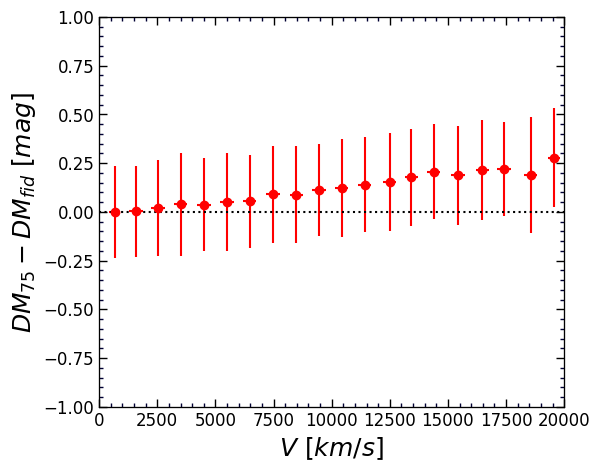

In [41]:
fig = py.figure(figsize=(5,5), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)


ax.set_xlabel(r'$V \/\/[km/s]$', fontsize=18) 
ax.set_ylabel(r'$DM_{75} - DM_{fid}\/\/[mag]$', fontsize=18)

ax.plot([0,20000], [0,0], ':', color='black')
set_axes(ax, (0,20000), (-1,1), fontsize=12)



X = V_cf4_
Y = DM75_  -  DM_fid   
makePlot(ax, X, Y, scatter=False)